In [1]:
%pylab inline
#import matplotlib as plt
#import numpy as np
import pandas as pd
import uncertainties
from uncertainties import unumpy as unp
from uncertainties import ufloat

def gaussian(x, mu, sigma, B, A):
    return A * np.e ** ((-1 * (x - mu) ** 2) / (2 * sigma ** 2)) + B

def gausfit_pm(x, y, p0=None):
    import numpy as np
    return fit_pm(x, y, func=lambda x, mu, sigma, B, A: A * np.e ** ((-1 * (x - mu) ** 2) / (2 * sigma ** 2)) + B,
                  p0=p0)

def lorentz(x, x_0, gamma, a, d):
    return a * 1/(1 + ((x - x_0)/gamma)**2) + d
def lorentzfit_pm(x, y, p0=None):
    import numpy as np
    return fit_pm(x, y, func=lambda x, x_0, gamma, a, d: a * 1/(1 + ((x - x_0)/gamma)**2) + d,p0=p0)

def line(x,a,b):
    return a * x + b

def linfit_pm(x, y, p0=None):
    return fit_pm(x, y, func=lambda x, a, b,: a * x + b, p0=p0)


def fit_pm(x, y, func=lambda x: x, p0=None):
    """
        fit_pm takes data points and makes an exponential curve fit. It returns
        the parameters with errors and the coefficient of determination
        Parameters:
        -----------
        x: x-value of the data points.
        y: y-value of the data points.
        func: Function to be fitted to.
        Returns:
        -----------
        list: Gives back a list with the parameters of an expotential function the
              corresponding errors and the coefficient of determination.
    """
    from scipy.optimize import curve_fit
    import numpy as np
    popt, pcov = curve_fit(func, x, y, p0=p0)
    params = popt.copy()
    errors = np.sqrt(np.diag(pcov))
    r = np.array(y) - func(np.array(x), *params)
    rss = np.sum(r ** 2)
    tss = np.sum((y - np.mean(y)) ** 2)
    R_2 = 1 - (rss / tss)
    try:
        from uncertainties import unumpy as unp
        return unp.uarray(params, errors), R_2
    except:
        return np.array(params), np.array(errors), R_2


def val(x):
    from uncertainties import unumpy
    try:
        return unumpy.nominal_values(x)
    except TypeError:
        return x


def err(x):
    from uncertainties import unumpy
    return unumpy.std_devs(x)

Populating the interactive namespace from numpy and matplotlib


In [2]:
filename = "-2.5_"+"1"+filename_r
plots=True
save=True
values=False
printt=False
def linfitter(x,y):
    itera = 0
    start = 0
    stop = 0
    lastval = 0
    trigger = False
    for item in y:
        if (lastval-item) > 1:  # rampe primed
            trigger = True
        if trigger and item > -1 and start == 0: # startwert für sauberen fit
            start = itera
        if trigger and item > 1:  #  endwert sauberer fit
            stop = itera
            break
        itera += 1
        lastval = item
    return linfit_pm(x[start:stop],y[start:stop])


def lorenzer(x,y):
    if abs(abs(y[0])+abs(max(y)))>abs(abs(y[0])-abs(min(y))):  # 0°-> peak über start
        print("0deg")
        return lorentzfit_pm(x,y,p0 = (x[list(y).index(max(y))],1e-5,max(y)-y[0],y[0]))
    if abs(y[0]+max(y))<abs(y[0]-min(y)):  # 90° -> peak unter start
        return lorentzfit_pm(x,y,p0 = (x[list(y).index(min(y))],1e-5,min(y)-y[0],y[0]))


# konstanten
k = 3.363e-4
gJ = 1.4838
muB = 9.274009e-24
hb = 1.0546e-34

# daten einlesen, in arrays umwandeln
df = pd.read_csv(filename)  # einlesen
time = df.iloc[0:,0].to_numpy()  # zeit
ch1 = df.iloc[0:,1].to_numpy()  # signal
ch2 = df.iloc[0:,2].to_numpy()  # magnetfeld
if plots:
    #nice plot
    ### FigureSize

    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 10
    fig_size[1] = 7.5
    plt.rcParams["figure.figsize"] = fig_size

    ###   Errors / Fit / Plot

    plt.plot(time,ch1,label="Photomultiplier")
    plt.plot(time,ch2,label="Magnetfeld")
    lin_params ,lin_r_2 = linfitter(time,ch2) # linfit

    plt.plot(time,line(time,*val(lin_params)),label="Linearer Fit")



    ###   Label / Title

    plt.ylabel(r'$U\,[\mathrm{V}]$', fontsize=13)
    plt.xlabel(r'Zeit $\left[s\right]$', fontsize=13)
    plt.title(filename, fontsize=20)

    ###   Axes / Grid

    axes = plt.gca()  ##  Searches current Axes

    #axes.set_xlim([0,0.8])
    #axes.set_ylim([-1,110])

    #axes.set_yticks([0,10,20,30,40,50,60,70,80,90,100,110])
    #axes.set_xticks([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8])

    axes.grid(which='major', linestyle='-', linewidth='1', color='black')
    axes.grid(which='minor', linestyle=':', color='gray')
    axes.minorticks_on()

    plt.legend()
    plt.savefig(filename[:-4]+"_raw"+".png")
    plt.show()

# B(t) bestimmen
lin_params ,lin_r_2 = linfitter(time,ch2) # linfit
(a,b) = lin_params
if printt:
    print("line params",a,b,"\n")
B = (a*time+b)*k
if printt:
    print("B",B,"\n")
# fit B(t) signal
lor_params,lor_r_2 = lorenzer(val(B),ch1)
if printt:
    print("lor params",lor_params,"\n")
x_0, gamma, a, d = lor_params

if plots:
    #nice plot
    ### FigureSize

    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 10
    fig_size[1] = 7.5
    plt.rcParams["figure.figsize"] = fig_size

    ###   Errors / Fit / Plot

    plt.plot(val(B),ch1,label="Photomultiplier")
    #plt.plot(val(B),ch2_90,label="Magnetfeld")
    plt.plot(val(B),lorentz(val(B),*val(lor_params)),label="Lorentzfit")



    ###   Label / Title

    plt.ylabel(r'$U\,[\mathrm{V}]$', fontsize=13)
    plt.xlabel(r'Magnetfeld $\left[T\right]$', fontsize=13)
    plt.title(filename, fontsize=20)

    ###   Axes / Grid

    axes = plt.gca()  ##  Searches current Axes

    #axes.set_xlim([0,0.8])
    #axes.set_ylim([-1,110])

    #axes.set_yticks([0,10,20,30,40,50,60,70,80,90,100,110])
    #axes.set_xticks([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8])

    axes.grid(which='major', linestyle='-', linewidth='1', color='black')
    axes.grid(which='minor', linestyle=':', color='gray')
    axes.minorticks_on()

    plt.legend()
    if save:
        plt.savefig(filename[:-4]+"_lorenz"+'.png')
    plt.show()


FWHM = 2*gamma
if printt:
    print(FWHM)
# tau berechnen
tau = hb/(gJ*muB*FWHM)
if values:
    print(tau,[lin_params,lor_params])
else: 
    print(tau)

NameError: name 'filename_r' is not defined

In [ ]:
filename = "87.5_"+"1"+filename_r
plots=True
save=True
values=False
printt=False
def linfitter(x,y):
    itera = 0
    start = 0
    stop = 0
    lastval = 0
    trigger = False
    for item in y:
        if (lastval-item) > 1:  # rampe primed
            trigger = True
        if trigger and item > -1 and start == 0: # startwert für sauberen fit
            start = itera
        if trigger and item > 1:  #  endwert sauberer fit
            stop = itera
            break
        itera += 1
        lastval = item
    return linfit_pm(x[start:stop],y[start:stop])


def lorenzer(x,y):
    if abs(abs(y[0])+abs(max(y)))>abs(abs(y[0])-abs(min(y))):  # 0°-> peak über start
        print("0deg")
        return lorentzfit_pm(x,y,p0 = (x[list(y).index(max(y))],1e-5,max(y)-y[0],y[0]))
    if abs(y[0]+max(y))<abs(y[0]-min(y)):  # 90° -> peak unter start
        return lorentzfit_pm(x,y,p0 = (x[list(y).index(min(y))],1e-5,min(y)-y[0],y[0]))


# konstanten
k = 3.363e-4
gJ = 1.4838
muB = 9.274009e-24
hb = 1.0546e-34

# daten einlesen, in arrays umwandeln
df = pd.read_csv(filename)  # einlesen
time = df.iloc[0:,0].to_numpy()  # zeit
ch1 = df.iloc[0:,1].to_numpy()  # signal
ch2 = df.iloc[0:,2].to_numpy()  # magnetfeld
if plots:
    #nice plot
    ### FigureSize

    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 10
    fig_size[1] = 7.5
    plt.rcParams["figure.figsize"] = fig_size

    ###   Errors / Fit / Plot

    plt.plot(time,ch1,label="Photomultiplier")
    plt.plot(time,ch2,label="Magnetfeld")
    lin_params ,lin_r_2 = linfitter(time,ch2) # linfit

    plt.plot(time,line(time,*val(lin_params)),label="Linearer Fit")



    ###   Label / Title

    plt.ylabel(r'$U\,[\mathrm{V}]$', fontsize=13)
    plt.xlabel(r'Zeit $\left[s\right]$', fontsize=13)
    plt.title(filename, fontsize=20)

    ###   Axes / Grid

    axes = plt.gca()  ##  Searches current Axes

    #axes.set_xlim([0,0.8])
    #axes.set_ylim([-1,110])

    #axes.set_yticks([0,10,20,30,40,50,60,70,80,90,100,110])
    #axes.set_xticks([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8])

    axes.grid(which='major', linestyle='-', linewidth='1', color='black')
    axes.grid(which='minor', linestyle=':', color='gray')
    axes.minorticks_on()

    plt.legend()
    plt.savefig(filename[:-4]+"_raw"+".png")
    plt.show()

# B(t) bestimmen
lin_params ,lin_r_2 = linfitter(time,ch2) # linfit
(a,b) = lin_params
if printt:
    print("line params",a,b,"\n")
B = (a*time+b)*k
if printt:
    print("B",B,"\n")
# fit B(t) signal
lor_params,lor_r_2 = lorenzer(val(B),ch1)
if printt:
    print("lor params",lor_params,"\n")
x_0, gamma, a, d = lor_params

if plots:
    #nice plot
    ### FigureSize

    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 10
    fig_size[1] = 7.5
    plt.rcParams["figure.figsize"] = fig_size

    ###   Errors / Fit / Plot

    plt.plot(val(B),ch1,label="Photomultiplier")
    #plt.plot(val(B),ch2_90,label="Magnetfeld")
    plt.plot(val(B),lorentz(val(B),*val(lor_params)),label="Lorentzfit")



    ###   Label / Title

    plt.ylabel(r'$U\,[\mathrm{V}]$', fontsize=13)
    plt.xlabel(r'Magnetfeld $\left[T\right]$', fontsize=13)
    plt.title(filename, fontsize=20)

    ###   Axes / Grid

    axes = plt.gca()  ##  Searches current Axes

    #axes.set_xlim([0,0.8])
    #axes.set_ylim([-1,110])

    #axes.set_yticks([0,10,20,30,40,50,60,70,80,90,100,110])
    #axes.set_xticks([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8])

    axes.grid(which='major', linestyle='-', linewidth='1', color='black')
    axes.grid(which='minor', linestyle=':', color='gray')
    axes.minorticks_on()

    plt.legend()
    if save:
        plt.savefig(filename[:-4]+"_lorenz"+'.png')
    plt.show()


FWHM = 2*gamma
if printt:
    print(FWHM)
# tau berechnen
tau = hb/(gJ*muB*FWHM)
if values:
    print(tau,[lin_params,lor_params])
else: 
    print(tau)

In [9]:
def analysis(filename,plots=False,save=False,values=False, printt=False,**kwargs):
    def linfitter(x,y):
        itera = 0
        start = 0
        stop = 0
        lastval = 0
        trigger = False
        for item in y:
            if (lastval-item) > 1:  # rampe primed
                trigger = True
            if trigger and item > -1 and start == 0: # startwert für sauberen fit
                start = itera
            if trigger and item > 1:  #  endwert sauberer fit
                stop = itera
                break
            itera += 1
            lastval = item
        return linfit_pm(x[start:stop],y[start:stop])


    def lorenzer(x,y):
        if abs(abs(y[0])+abs(max(y)))>abs(abs(y[0])-abs(min(y))):  # 0°-> peak über start
            if printt:
                print("0 deg")
            return lorentzfit_pm(x,y,p0 = (x[list(y).index(max(y))],1e-5,max(y)-y[0],y[0]))
        if abs(y[0]+max(y))<abs(y[0]-min(y)):  # 90° -> peak unter start
            if printt:
                print("90 deg")
            return lorentzfit_pm(x,y,p0 = (x[list(y).index(min(y))],1e-5,min(y)-y[0],y[0]))


    # konstanten
    k = 3.363e-4
    gJ = 1.4838
    muB = 9.274009e-24
    hb = 1.0546e-34
    
    # daten einlesen, in arrays umwandeln
    df = pd.read_csv(filename)  # einlesen
    time = df.iloc[0:,0].to_numpy()  # zeit
    ch1 = df.iloc[0:,1].to_numpy()  # signal
    ch2 = df.iloc[0:,2].to_numpy()  # magnetfeld
    if plots:
        #nice plot
        ### FigureSize

        fig_size = plt.rcParams["figure.figsize"]
        fig_size[0] = 10
        fig_size[1] = 7.5
        plt.rcParams["figure.figsize"] = fig_size

        ###   Errors / Fit / Plot

        plt.plot(time,ch1,label="Photomultiplier")
        plt.plot(time,ch2,label="Magnetfeld")
        #plt.plot(time_90,lorentz(time_90,*val(lor_params)),label="Lorentzfit")



        ###   Label / Title

        plt.ylabel(r'$U\,[\mathrm{V}]$', fontsize=13)
        plt.xlabel(r'Zeit $\left[s\right]$', fontsize=13)
        plt.title(filename, fontsize=20)

        ###   Axes / Grid

        axes = plt.gca()  ##  Searches current Axes

        #axes.set_xlim([0,0.8])
        #axes.set_ylim([-1,110])

        #axes.set_yticks([0,10,20,30,40,50,60,70,80,90,100,110])
        #axes.set_xticks([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8])

        axes.grid(which='major', linestyle='-', linewidth='1', color='black')
        axes.grid(which='minor', linestyle=':', color='gray')
        axes.minorticks_on()

        plt.legend()
        if save:
            
            plt.savefig(filename[:-4]+"_raw"+".png")
        plt.show()
        
    # B(t) bestimmen
    lin_params ,lin_r_2 = linfitter(time,ch2) # linfit
    (a,b) = lin_params
    if printt:
        print("line params",a,b,"\n")
    B = (a*time+b)*k
    if printt:
        print("B",B,"\n")
    # fit B(t) signal
    lor_params,lor_r_2 = lorenzer(val(B),ch1)
    if printt:
        print("lor params",lor_params,"\n")
    x_0, gamma, a, d = lor_params
    
    if plots:
        #nice plot
        ### FigureSize

        fig_size = plt.rcParams["figure.figsize"]
        fig_size[0] = 10
        fig_size[1] = 7.5
        plt.rcParams["figure.figsize"] = fig_size

        ###   Errors / Fit / Plot

        plt.plot(val(B),ch1,label="Photomultiplier")
        #plt.plot(val(B),ch2_90,label="Magnetfeld")
        plt.plot(val(B),lorentz(val(B),*val(lor_params)),label="Lorentzfit")



        ###   Label / Title

        plt.ylabel(r'$U\,[\mathrm{V}]$', fontsize=13)
        plt.xlabel(r'Magnetfeld $\left[T\right]$', fontsize=13)
        plt.title(filename, fontsize=20)

        ###   Axes / Grid

        axes = plt.gca()  ##  Searches current Axes

        #axes.set_xlim([0,0.8])
        #axes.set_ylim([-1,110])

        #axes.set_yticks([0,10,20,30,40,50,60,70,80,90,100,110])
        #axes.set_xticks([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8])

        axes.grid(which='major', linestyle='-', linewidth='1', color='black')
        axes.grid(which='minor', linestyle=':', color='gray')
        axes.minorticks_on()

        plt.legend()
        if save:
            plt.savefig(filename[:-4]+"_lorenz"+'.png')
        plt.show()
    
    
    FWHM = 2*gamma
    if printt:
        print(FWHM)
    # tau berechnen
    tau = hb/(gJ*muB*FWHM)
    if values:
        return tau,[lin_params,lor_params]
    else: 
        return tau

In [10]:
filename_l="-2.5_"
filename_r="_HM1508.csv"

In [11]:
analysis(filename_l+"1"+filename_r)

1.099207541902274e-07+/-1.2090208853386677e-09

In [13]:
intern=[]

for i in range(1,16):
    intern.append(analysis(filename_l+str(i)+filename_r,values=True,plots=False,save=1))
taus =[item[0] for item in intern]
params=[item[1] for item in intern]
lor_params=[item[1] for item in params]

# gamma is 2. param
gammas = [item[1] for item in lor_params]
gam_df = pd.DataFrame(gammas,index=range(1,16))
#print(gam_df.to_latex())

In [14]:
intern[1]

(1.2703146143543526e-07+/-1.5188005200500173e-09,
 [array([0.08702599198965755+/-0.00016209476373871287,
         -1.7252105391590717+/-0.0033257297123718004], dtype=object),
  array([2.975428749602531e-05+/-2.385520933499025e-07,
         3.0165018576139955e-05+/-3.6065589880696966e-07,
         2.5664534651064477+/-0.020299634125598875,
         -1.4427520398858256+/-0.0029461462029170982], dtype=object)])

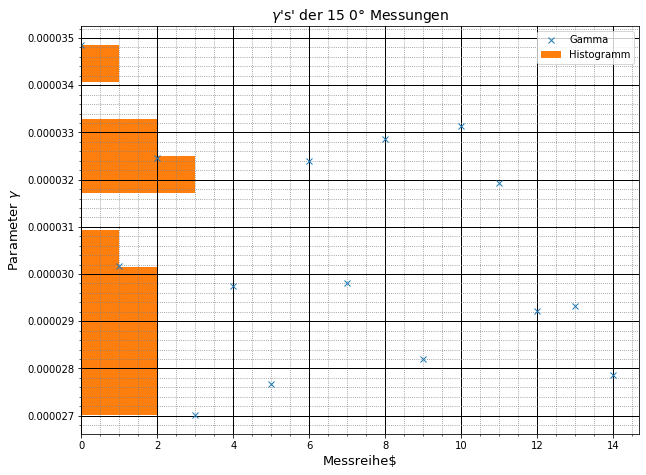

In [15]:

#nice plot
### FigureSize

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 7.5
plt.rcParams["figure.figsize"] = fig_size

###   Errors / Fit / Plot

plt.plot(val(gammas),"x",label="Gamma")
hist_0deg=plt.hist(val(gammas),orientation="horizontal",label="Histogramm")



###   Label / Title

plt.ylabel(r'Parameter $\gamma$', fontsize=13)
plt.xlabel(r'Messreihe$', fontsize=13)
plt.title("$\gamma$'s' der 15 0° Messungen", fontsize=14)

###   Axes / Grid

axes = plt.gca()  ##  Searches current Axes

#axes.set_xlim([0,0.8])
#axes.set_ylim([-1,110])

#axes.set_yticks([0,10,20,30,40,50,60,70,80,90,100,110])
#axes.set_xticks([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8])

axes.grid(which='major', linestyle='-', linewidth='1', color='black')
axes.grid(which='minor', linestyle=':', color='gray')
axes.minorticks_on()

plt.legend()
plt.savefig("gammas_hist"+'.png')
plt.show()

In [16]:
def meanDeviation(x: list):
    """Computes the mean deviation of a given list."""
    m = mean(x)
    return sqrt((1 / (len(x) - 1)) * sum((x - m) ** 2)) / sqrt(len(x))
gamma_stat = meanDeviation(val(gammas))
gamma_stat

6.075938865802572e-07

In [22]:
def analysis(filename,plots=False,save=True,values=False, printt=False,**kwargs):
    def linfitter(x,y):
        itera = 0
        start = 0
        stop = 0
        lastval = 0
        trigger = False
        for item in y:
            if (lastval-item) > 1:  # rampe primed
                trigger = True
            if trigger and item > -1 and start == 0: # startwert für sauberen fit
                start = itera
            if trigger and item > 1:  #  endwert sauberer fit
                stop = itera
                break
            itera += 1
            lastval = item
        return linfit_pm(x[start:stop],y[start:stop])


    def lorenzer(x,y):
        if abs(abs(y[0])+abs(max(y)))>abs(abs(y[0])-abs(min(y))):  # 0°-> peak über start
            if printt:
                print("0 deg")
            return lorentzfit_pm(x,y,p0 = (x[list(y).index(max(y))],1e-5,max(y)-y[0],y[0]))
        if abs(y[0]+max(y))<abs(y[0]-min(y)):  # 90° -> peak unter start
            if printt:
                print("90 deg")
            return lorentzfit_pm(x,y,p0 = (x[list(y).index(min(y))],1e-5,min(y)-y[0],y[0]))


    # konstanten
    k = 3.363e-4
    gJ = 1.4838
    muB = 9.274009e-24
    hb = 1.0546e-34
    gamma_stat = 6.075938865802572e-07
    
    # daten einlesen, in arrays umwandeln
    df = pd.read_csv(filename)  # einlesen
    time = df.iloc[0:,0].to_numpy()  # zeit
    ch1 = df.iloc[0:,1].to_numpy()  # signal
    ch2 = df.iloc[0:,2].to_numpy()  # magnetfeld
    if plots:
        #nice plot
        ### FigureSize

        fig_size = plt.rcParams["figure.figsize"]
        fig_size[0] = 10
        fig_size[1] = 7.5
        plt.rcParams["figure.figsize"] = fig_size

        ###   Errors / Fit / Plot

        plt.plot(time,ch1,label="Photomultiplier")
        plt.plot(time,ch2,label="Magnetfeld")
        #plt.plot(time_90,lorentz(time_90,*val(lor_params)),label="Lorentzfit")



        ###   Label / Title

        plt.ylabel(r'$U\,[\mathrm{V}]$', fontsize=13)
        plt.xlabel(r'Zeit $\left[s\right]$', fontsize=13)
        plt.title(filename, fontsize=20)

        ###   Axes / Grid

        axes = plt.gca()  ##  Searches current Axes

        #axes.set_xlim([0,0.8])
        #axes.set_ylim([-1,110])

        #axes.set_yticks([0,10,20,30,40,50,60,70,80,90,100,110])
        #axes.set_xticks([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8])

        axes.grid(which='major', linestyle='-', linewidth='1', color='black')
        axes.grid(which='minor', linestyle=':', color='gray')
        axes.minorticks_on()

        plt.legend()
        if save:
            
            plt.savefig(filename[:-4]+"_raw"+".png")
        plt.show()
        
    # B(t) bestimmen
    lin_params ,lin_r_2 = linfitter(time,ch2) # linfit
    (a,b) = lin_params
    if printt:
        print("line params",a,b,"\n")
    B = (a*time+b)*k
    if printt:
        print("B",B,"\n")
    # fit B(t) signal
    lor_params,lor_r_2 = lorenzer(val(B),ch1)
    if printt:
        print("lor params",lor_params,"\n")
    x_0, gamma, a, d = lor_params
    
    if plots:
        #nice plot
        ### FigureSize

        fig_size = plt.rcParams["figure.figsize"]
        fig_size[0] = 10
        fig_size[1] = 7.5
        plt.rcParams["figure.figsize"] = fig_size

        ###   Errors / Fit / Plot

        plt.plot(val(B),ch1,label="Photomultiplier")
        #plt.plot(val(B),ch2_90,label="Magnetfeld")
        plt.plot(val(B),lorentz(val(B),*val(lor_params)),label="Lorentzfit")



        ###   Label / Title

        plt.ylabel(r'$U\,[\mathrm{V}]$', fontsize=13)
        plt.xlabel(r'Magnetfeld $\left[T\right]$', fontsize=13)
        plt.title(filename, fontsize=20)

        ###   Axes / Grid

        axes = plt.gca()  ##  Searches current Axes

        #axes.set_xlim([0,0.8])
        #axes.set_ylim([-1,110])

        #axes.set_yticks([0,10,20,30,40,50,60,70,80,90,100,110])
        #axes.set_xticks([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8])

        axes.grid(which='major', linestyle='-', linewidth='1', color='black')
        axes.grid(which='minor', linestyle=':', color='gray')
        axes.minorticks_on()

        plt.legend()
        if save:
            plt.savefig(filename[:-4]+"_lorenz"+'.png')
        plt.show()
    
    gamma = ufloat(val(gamma),
                   np.sqrt(err(gamma)**2+gamma_stat**2)
                  )
    FWHM = 2*gamma
    if printt:
        print(FWHM)
    # tau berechnen
    tau = hb/(gJ*muB*FWHM)
    if values:
        return tau,[lin_params,lor_params]
    else: return tau

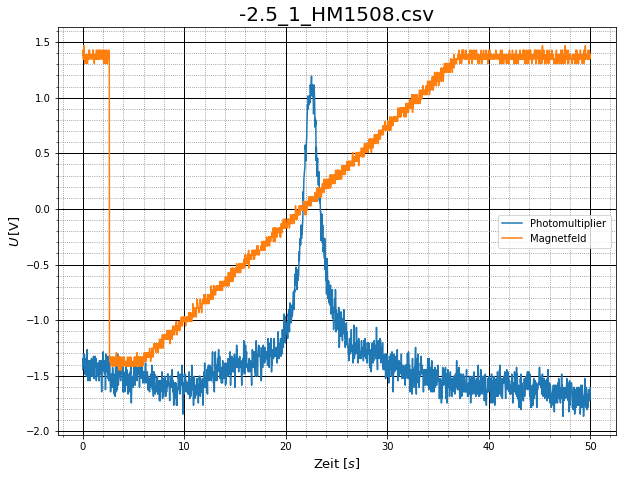

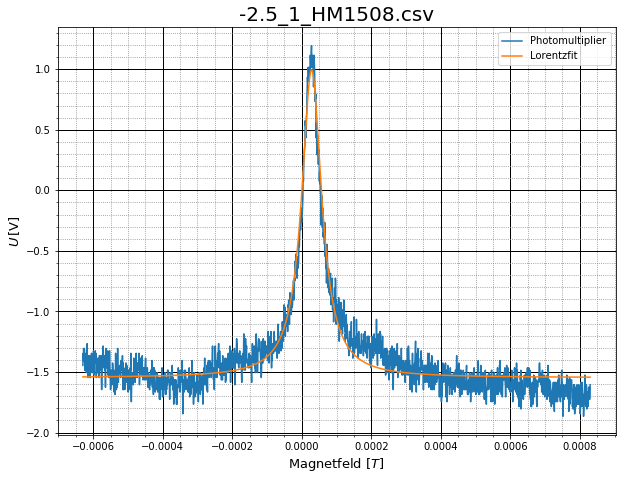

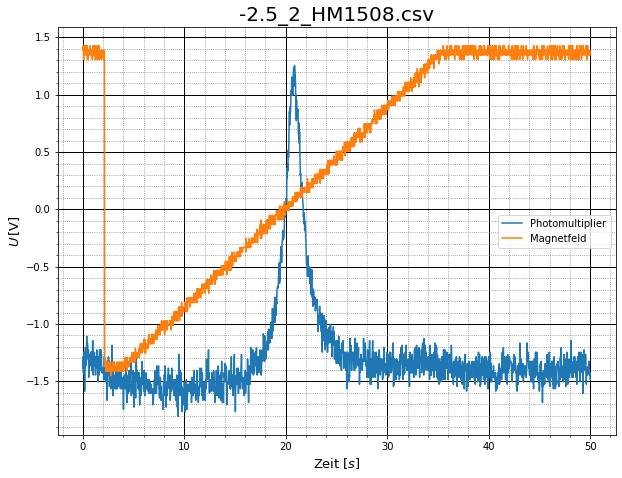

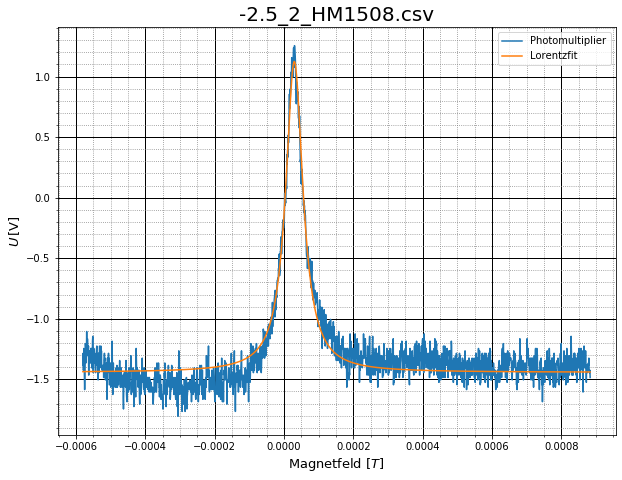

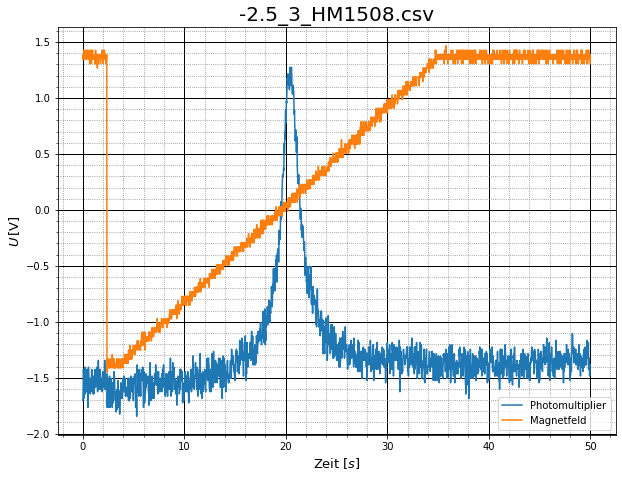

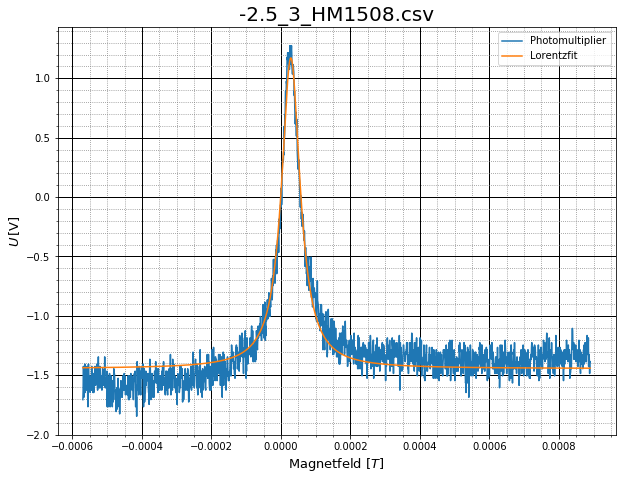

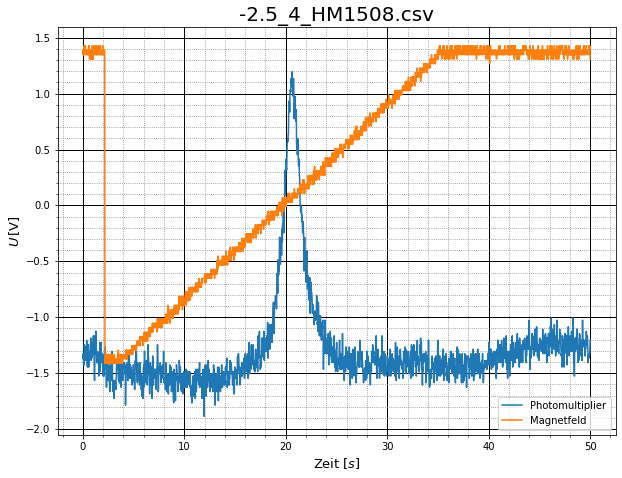

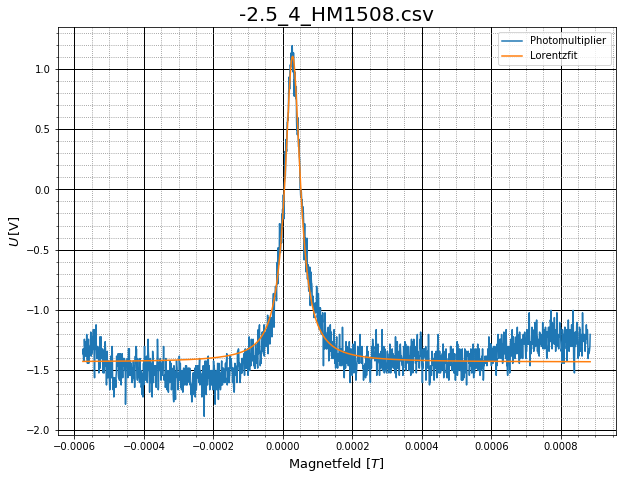

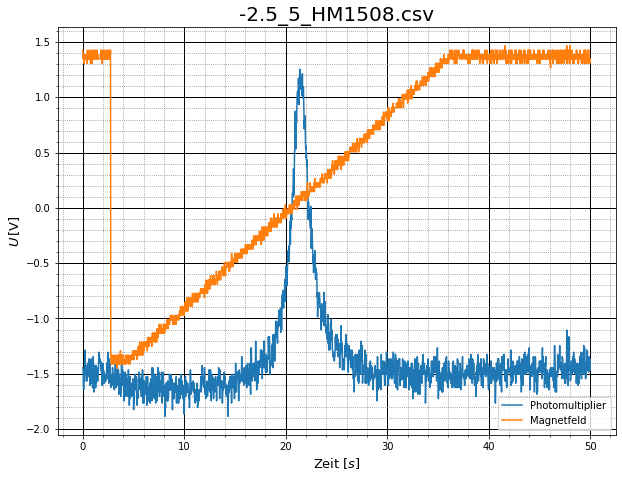

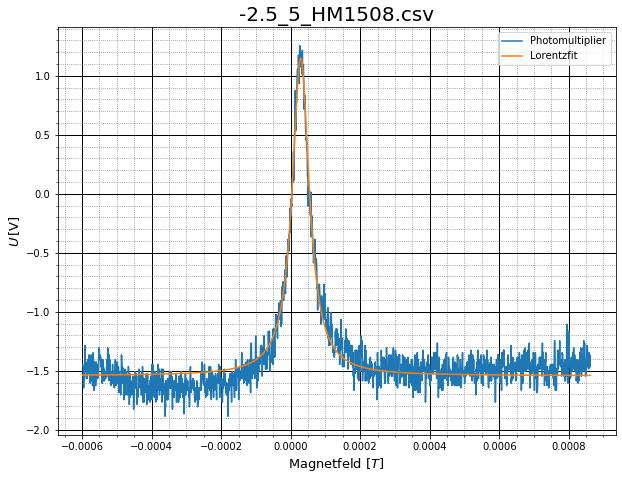

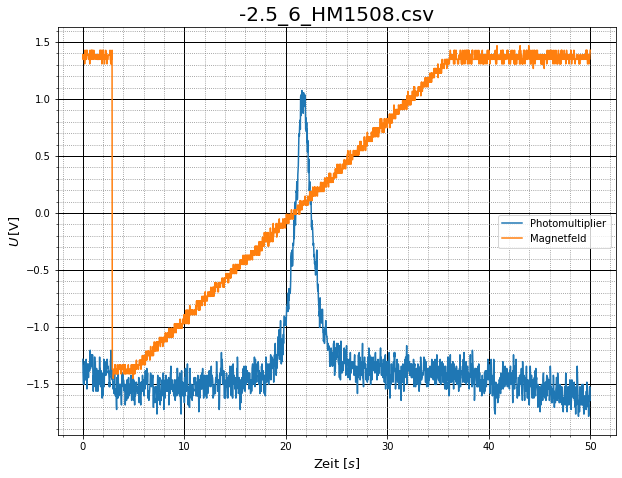

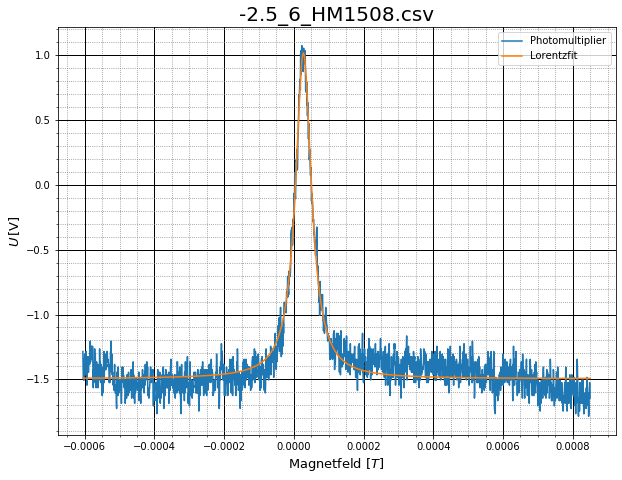

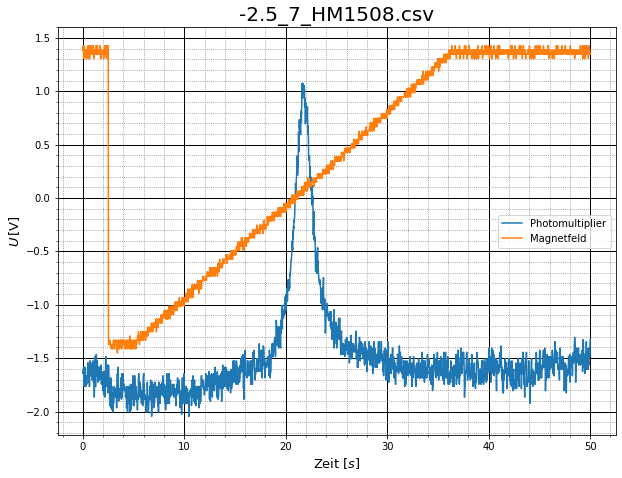

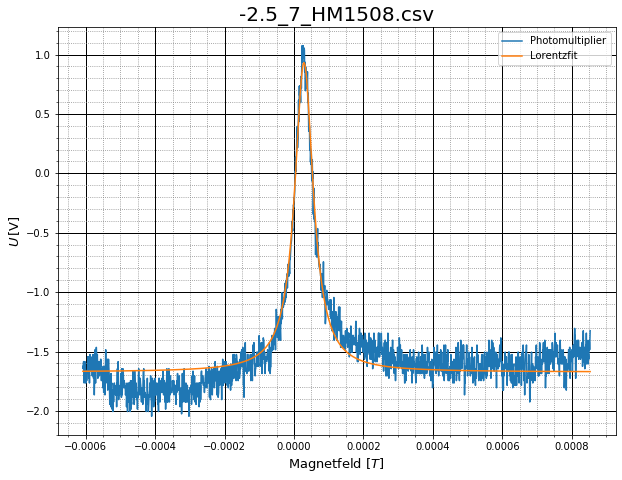

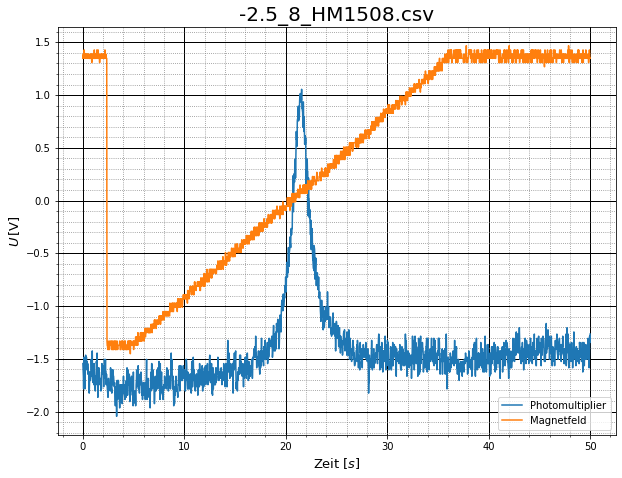

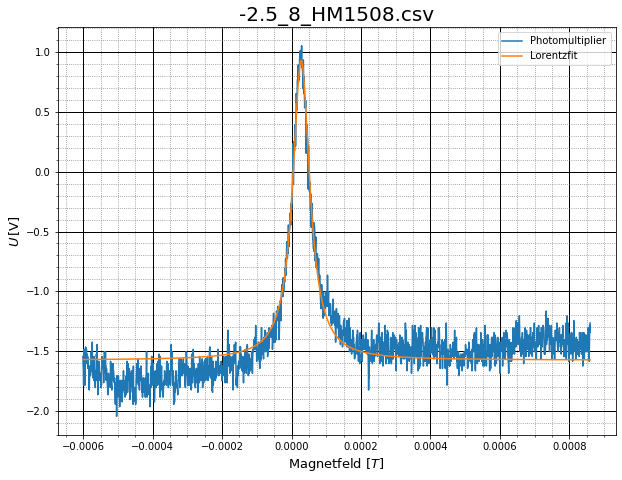

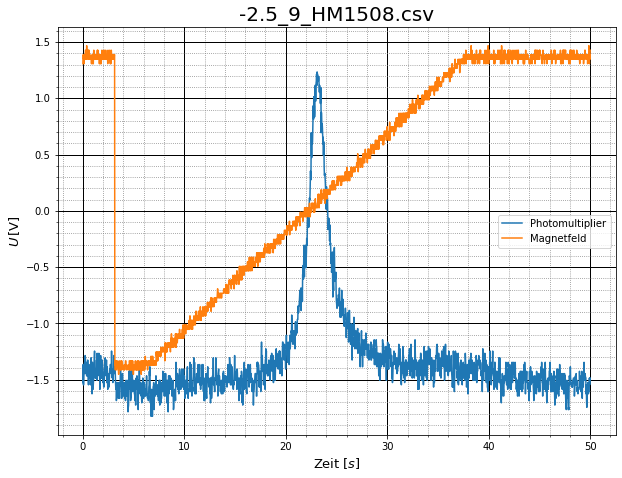

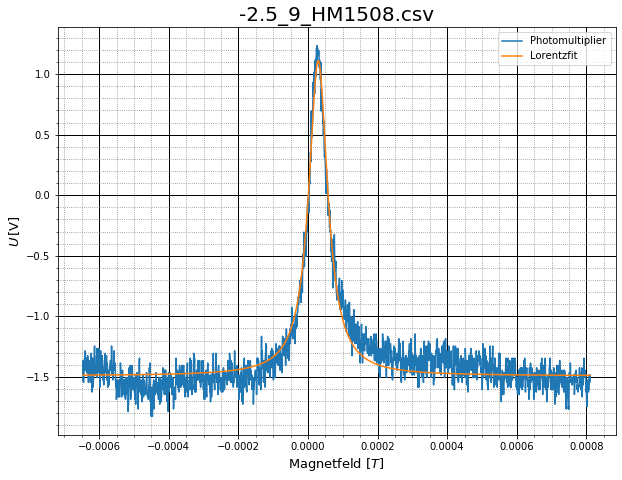

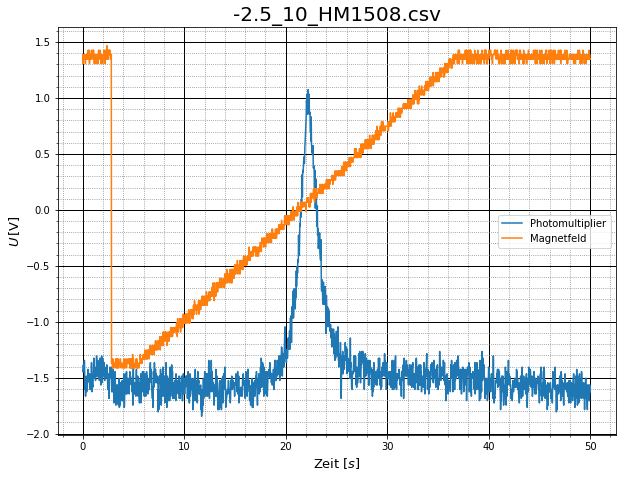

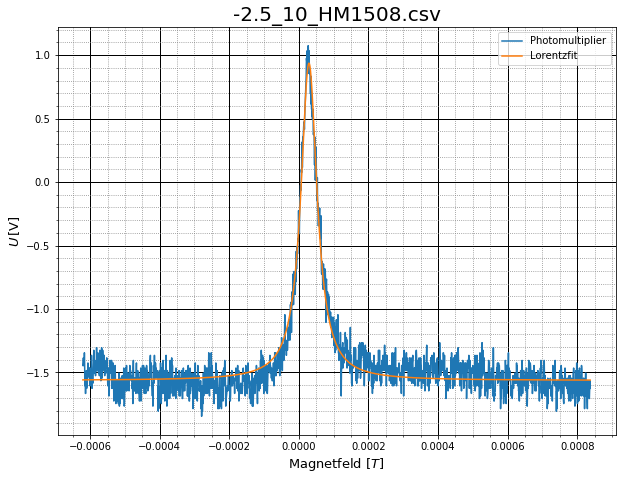

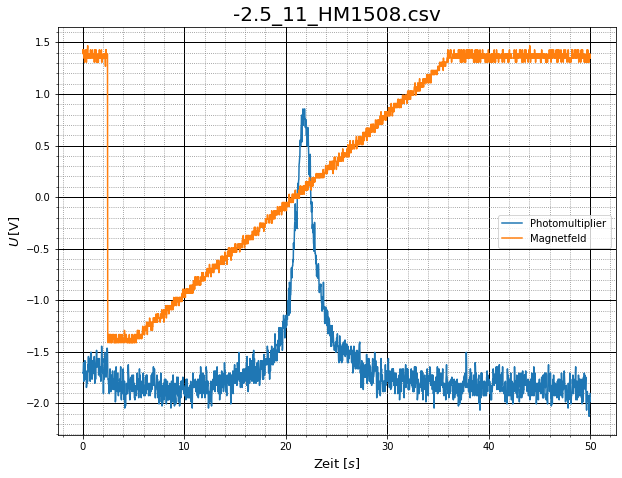

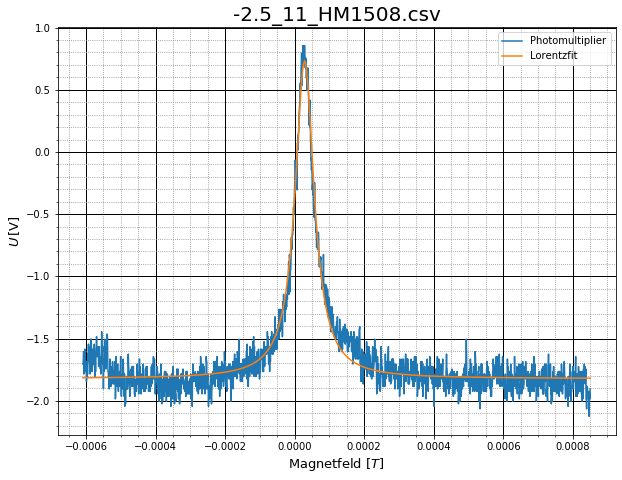

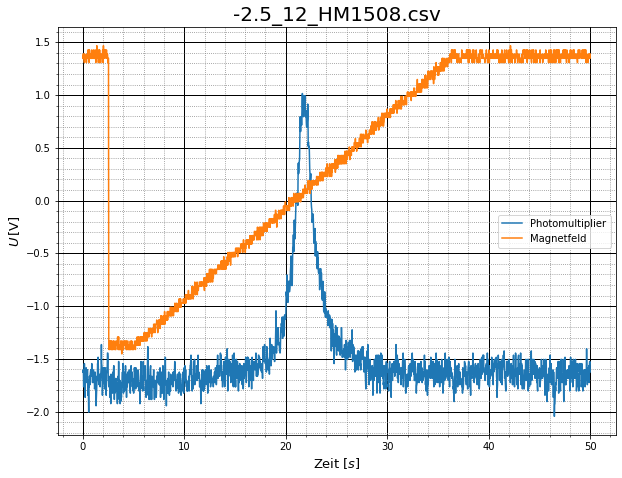

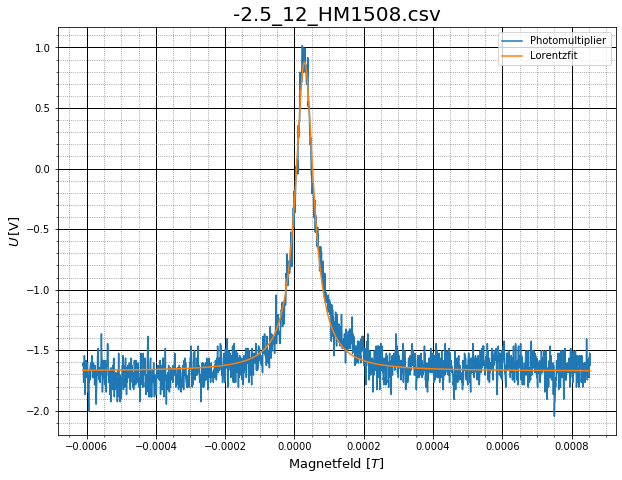

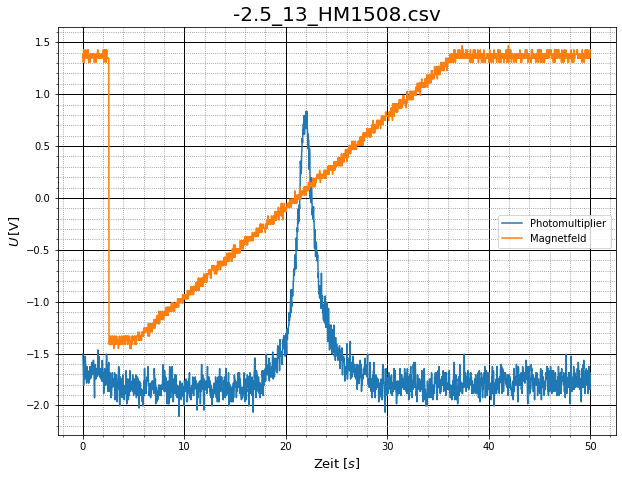

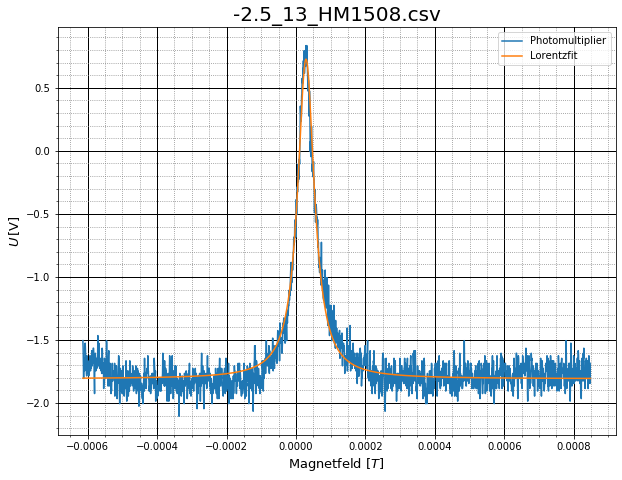

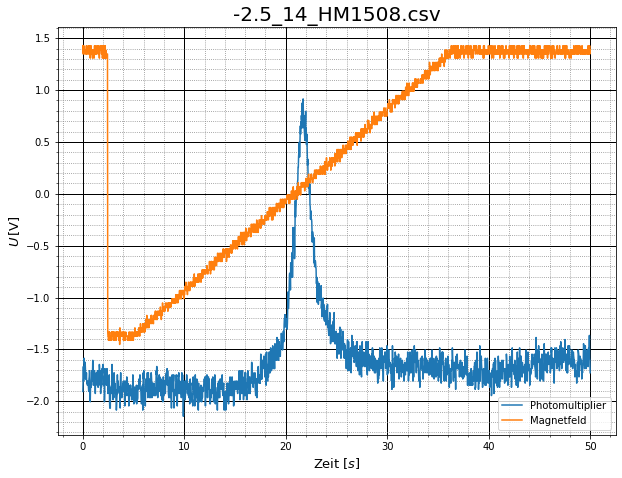

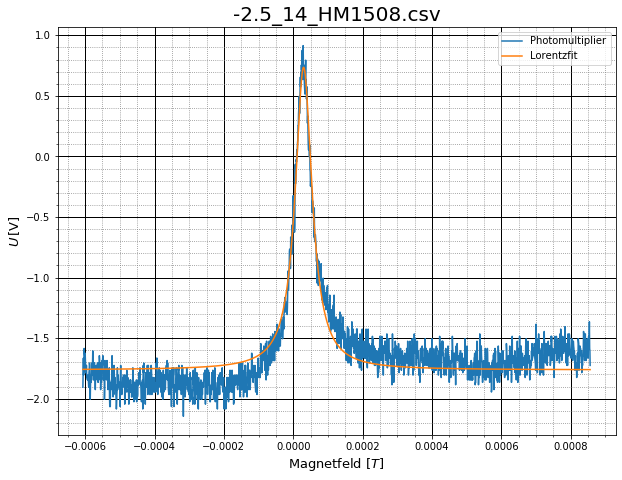

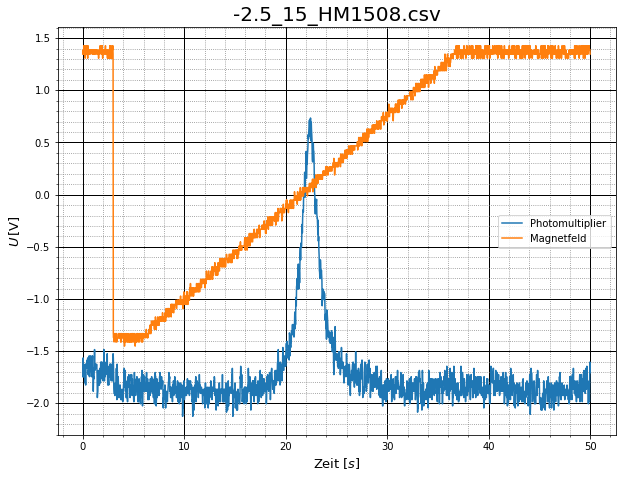

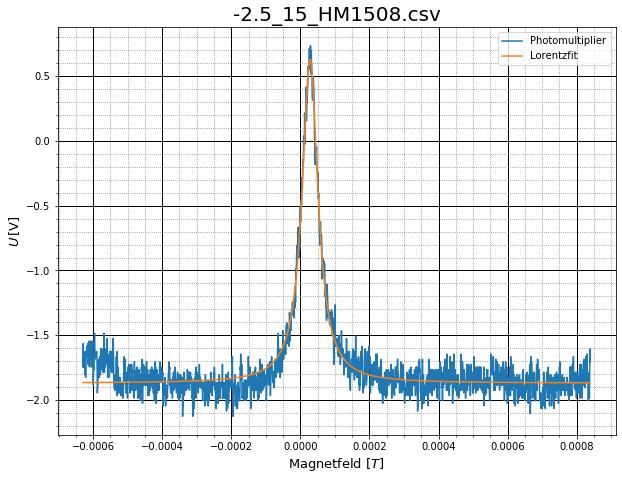

1.265734819693841e-07+/-7.749890651139579e-10

In [24]:
filename_l="-2.5_"
filename_r="_HM1508.csv"

taus=[]

for i in range(1,16):
    taus.append(analysis(filename_l+str(i)+filename_r,save=1,plots=1))

mean(taus)

In [11]:
def T_p(x):   #Konstanten als Fehlerlos angenommen wie suggested in anleitung
    x = x + 273.15
    T_c = 1764
    p_c = 1.67 * 10**5
    Tr = 1-(x/T_c)
    a1 = -4.57618368
    a2 = -1.40726277
    a3 = 2.36263541
    a4 = -31.0889985
    a5 = 58.0183959
    a6 = -27.6304546
    p = (  (T_c/x) * (a1*Tr + a2*Tr**1.89 + a3*Tr**2 + a4*Tr**8 + a5*Tr**8.5 + a6*Tr**9)  )
    p2 = e**(p)*p_c*10**6
    return p2